# GPflow with TF 2.0

In [18]:
import tensorflow as tf
import gpflow

import numpy as np
import matplotlib.pyplot as plt
import datetime
import io

np.random.seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function) 

(0, 10)

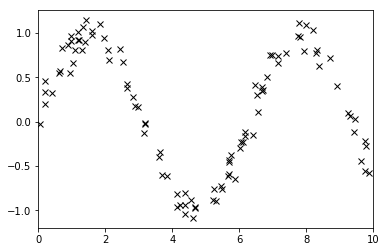

In [19]:
def noisy_sin(x): 
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

N, Ntest = 100, 500
X, Xtest = np.random.rand(N, 1) * 10, np.random.rand(Ntest, 1) * 10
Y, Ytest = noisy_sin(X), noisy_sin(Xtest)

plt.plot(X, Y, 'xk')
plt.xlim(0, 10)

Working with Tensorflow Datasets is an efficient way to rapidly shuffle, iterate and batch from data.

In [20]:
dataset = tf.data.Dataset.from_tensors((X, Y))
test_dataset = tf.data.Dataset.from_tensors((Xtest, Ytest))

## Define a GP model

In GPflow2.0, we use tf.Module to build all our models, as well as, their components (kernels, likelihoods, parameters, etc.). 

In [31]:
M = 10
kern = gpflow.kernels.RBF(variance=2.)
lik = gpflow.likelihoods.Gaussian()
Z = np.linspace(0, 10, M).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)

def plotting_regression(m): 
    fig = plt.figure(0)
    ## generate test points for prediction
    xx = np.linspace(0, 10, 100).reshape(100, 1) # test points must be of shape (n, 1)

    ## predict mean and variance of latent at test points
    mean, var = m.predict_f(xx)

    ## generate samples from posterior
    samples = m.predict_f_samples(xx, 10)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.ylim(-2., +2.)
    plt.xlim(0, 10)
    plt.close()
    return fig 

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```

In [32]:
from gpflow.utilities.training import set_trainable

set_trainable(lik, False)
set_trainable(kern.variance, False)

We can use ```param.assign(value)``` to assign a value to a parameter:

In [33]:
kern.lengthscale.assign(1.5)

All these changes are reflect when we print a summary of the model using ```print_summary```

In [34]:
# from gpflow.utilities.printing import print_summary
# print_summary(model)

## Training using Gradient Tapes

In TensorFlow2.0, we can optimise (trainable) model parameters with Tensorflow optimizers using GradientTapes. In this simple example, we perform one gradient update of the Adam optimizer to minimize the negative marginal log likelihood (or ELBO) of the model.

In [35]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape: 
    tape.watch(model.trainable_variables)
    loss = model.neg_log_marginal_likelihood(X, Y)
    grads = tape.gradient(loss, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

For a more elaborare example of a gradient update we can define an ```optimization_step``` that uses decorator ```tf.function``` on a closure. A closure is callable that returns the model objective evaluated at a given dataset when called.

In [36]:
class Closure: 
    def set_data(self, batch): 
        self.X, self.Y = batch
        
    @tf.function
    def __call__(self): 
        return model.neg_log_marginal_likelihood(self.X, self.Y)

closure = Closure()

def optimization_step(batch): 
    closure.set_data(batch)
    with tf.GradientTape() as tape: 
        tape.watch(model.trainable_variables)
        loss = closure()
        grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We can make use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset: 

In [37]:
def simple_training_loop(model, batch_size, epochs: int):
    for epoch in range(epochs):
        dataset.shuffle(buffer_size=10000)
        batches_epoch = iter(dataset.batch(batch_size=batch_size))
        for batch in batches_epoch:
            optimization_step(batch)
        if (epoch + 1) % 100 == 0: 
            print(r'Epoch %i completed: ELBO training set %f4' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y))
                 )

In [38]:
simple_training_loop(model, batch_size=10, epochs=1000)

Epoch 100 completed: ELBO training set 175.2092604
Epoch 200 completed: ELBO training set 148.7926434
Epoch 300 completed: ELBO training set 131.6178494
Epoch 400 completed: ELBO training set 120.9132944
Epoch 500 completed: ELBO training set 114.4491514
Epoch 600 completed: ELBO training set 110.5687754
Epoch 700 completed: ELBO training set 108.2106554
Epoch 800 completed: ELBO training set 106.7320284
Epoch 900 completed: ELBO training set 105.7661594
Epoch 1000 completed: ELBO training set 105.1155364


## Monitoring 

We can monitor the training procedure using TensorFlow summary. First we create a summary writer object under which we can write scalar and images.

In [39]:
model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)
closure = Closure()

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def monitored_training_loop(model, batch_size: int, epochs: int, log_dir: str):
    summary_writer = tf.summary.create_file_writer(log_dir)
    for epoch in range(epochs):
        dataset.shuffle(buffer_size=10000)
        batches_epoch = iter(dataset.batch(batch_size=batch_size))
        for batch in batches_epoch:
            optimization_step(batch)

        with summary_writer.as_default():
            tf.summary.scalar('loss', data=model.neg_log_marginal_likelihood(X,Y), step=epoch)
            tf.summary.scalar('lik.variance', data=model.likelihood.variance, step=epoch)
            tf.summary.scalar('kern.ls', data=model.kernel.lengthscale, step=epoch)
            tf.summary.scalar('kern.variance', data=model.kernel.variance, step=epoch)
            
        if (epoch + 1) % 100 == 0: 
            print(r'Epoch %i completed: ELBO training set %f4' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y))
                 )
            fig = plotting_regression(model)
            image = plot_to_image(fig)
            with summary_writer.as_default():
                tf.summary.image('model samples', data=image, step=epoch)

In [40]:
log_dir = '/tmp/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(r'Logs folder path: %s' % (log_dir))

monitored_training_loop(model, batch_size=10, epochs=1000, log_dir=log_dir)

Logs folder path: /tmp/logs/20190619-164740
Epoch 100 completed: ELBO training set 122.7614824
Epoch 200 completed: ELBO training set 110.3138694
Epoch 300 completed: ELBO training set 106.5375514
Epoch 400 completed: ELBO training set 105.0469204
Epoch 500 completed: ELBO training set 104.3720594
Epoch 600 completed: ELBO training set 104.0340454
Epoch 700 completed: ELBO training set 103.8490794
Epoch 800 completed: ELBO training set 103.7393254
Epoch 900 completed: ELBO training set 103.6692304
Epoch 1000 completed: ELBO training set 103.6215494


Then, we can then use Tensorboard to examine the training procedure more in detail.

In [13]:
# ! tensorboard --logdir '/tmp/logs/'

## Checkpointing: saving and loading models

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure.

In [14]:
model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)
closure = Closure()

def checkpointing_training_loop(model, batch_size: int, epochs: int, manager: tf.train.CheckpointManager):
    
    for epoch in range(epochs):
        dataset.shuffle(buffer_size=10000)
        batches_epoch = iter(dataset.batch(batch_size=batch_size))
        for batch in batches_epoch:
            optimization_step(batch)
            
        if (epoch + 1) % 100 == 0: 
            ckpt_path = manager.save()
            print(r'Epoch %i completed: ELBO training set %f3, model checkpointing saved at %s' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y), ckpt_path)
                 )

In [15]:
ckpt = tf.train.Checkpoint(model=model)
checkpoint_path = '/tmp/tf_ckpts/' + datetime.datetime.now().strftime("%Y%m%d-%H%M")

manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)         
print(r'Checkpoint folder path at: %s' % (checkpoint_path))

checkpointing_training_loop(model, batch_size=10, epochs=1000, manager=manager)

Checkpoint folder path at: /tmp/tf_ckpts/20190619-1645
Epoch 100 completed: ELBO training set 118.1122633, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-1
Epoch 200 completed: ELBO training set 108.1360393, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-2
Epoch 300 completed: ELBO training set 105.4332903, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-3
Epoch 400 completed: ELBO training set 104.4496843, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-4
Epoch 500 completed: ELBO training set 104.0296083, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-5
Epoch 600 completed: ELBO training set 103.8254103, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-6
Epoch 700 completed: ELBO training set 103.7141443, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-7
Epoch 800 completed: ELBO training set 103.6471043, model checkpointing saved at /tmp/tf_ckpts/20190619-1645/ckpt-8
Epoch 900 complet

Once the models have been saved, we can resore them using ```tf.train.Checkpoint.restore```.

In [16]:
for i, recorded_checkpoint in enumerate(manager.checkpoints): 
    ckpt.restore(recorded_checkpoint)
    print(r'Restored model from epoch %i : ELBO training set %f3' % (
        i, model.neg_log_marginal_likelihood(X,Y))
         )

Restored model from epoch 0 : ELBO training set 118.1122633
Restored model from epoch 1 : ELBO training set 108.1360393
Restored model from epoch 2 : ELBO training set 105.4332903
Restored model from epoch 3 : ELBO training set 104.4496843
Restored model from epoch 4 : ELBO training set 104.0296083
Restored model from epoch 5 : ELBO training set 103.8254103
Restored model from epoch 6 : ELBO training set 103.7141443
Restored model from epoch 7 : ELBO training set 103.6471043
Restored model from epoch 8 : ELBO training set 103.6031493
Restored model from epoch 9 : ELBO training set 103.5724103
